## 1. Configuración del Entorno y Librerías
Para iniciar, se preparó el espacio de trabajo con las librerías necesarias. Se eligió Librosa por su facilidad para manejar audio y Scikit-learn para la parte estadística. Se incluyó un filtro de advertencias (warnings) para que los mensajes de actualización de Python no ensucien la presentación de los resultados.

In [11]:
import os
import librosa
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## 2. Procesamiento de señales y limpieza de datos (Pasos 03 y 04)
Al revisar el dataset colectivo, se notó mucha inconsistencia. Algunos audios tenían el volumen muy bajo y otros muy alto, además de que las etiquetas venían con mayúsculas, espacios o nombres variados como "nulo" y "nula".

Para solucionar esto, se programó una limpieza automática que unificó todo a minúsculas, evitando que el modelo creara clases duplicadas. También se aplicó la normalización y el recorte de silencios (trim). Se consideró este paso vital porque, sin él, la IA se distraería con el ruido de fondo o el nivel de volumen en lugar de aprender el sonido real de la habitación. Finalmente, se extrajeron los 13 MFCCs, el ZCR y el RMS para crear la firma acústica de cada actividad.

In [12]:
import os  # Added import for os module
import numpy as np  # Import numpy for array operations
import librosa  # Import librosa for audio processing
import pandas as pd  # Import pandas for DataFrame creation

# Ruta de las grabaciones
ruta_audios = r"C:\Users\Marie\OneDrive\Documentos\CICESE\Segundo Cuatrimestre\CDSI\Practica1\Audios"

datos_finales = []

for root, dirs, files in os.walk(ruta_audios):
    for archivo in files:
        if archivo.endswith(".wav"):
            try:
                # Limpieza de Datos
                nombre_base = archivo.replace(".wav", "").lower().strip()
                partes = nombre_base.split('_')
                
                if len(partes) >= 2:
                    clase = partes[1].strip()
                    if clase == 'nulo': clase = 'nula'
                    
                    path_completo = os.path.join(root, archivo)
                    y, sr = librosa.load(path_completo, sr=None)
                    
                    # Paso 3: Eliminacion de Ruido y Normalizacion
                    
                    # Reducción de ruido estacionario: 
                    y_sin_ruido, _ = librosa.effects.trim(y, top_db=30) 
                    
                    # Normalización de amplitud:
                    y_final = librosa.util.normalize(y_sin_ruido)
                    
                    # Paso 4: Descriptores
                    zcr = np.mean(librosa.feature.zero_crossing_rate(y_final))
                    rms = np.mean(librosa.feature.rms(y=y_final))
                    mfccs = librosa.feature.mfcc(y=y_final, sr=sr, n_mfcc=13)
                    mfccs_promedio = np.mean(mfccs, axis=1)
                    
                    fila = [archivo, clase, zcr, rms] + list(mfccs_promedio)
                    datos_finales.append(fila)
                    
            except Exception as e:
                print(f"Error en archivo {archivo}: {e}")

columnas = ['Archivo', 'Clase', 'ZCR', 'RMS'] + [f'MFCC_{i+1}' for i in range(13)]
df = pd.DataFrame(datos_finales, columns=columnas)
print(f"Proceso terminado. \nCantidad de Audios utilizados: {len(df)}")

Proceso terminado. 
Cantidad de Audios utilizados: 179


## 3. Preparación de los datos para entrenamiento
Antes de entrenar, se separó un 20% de los datos para evaluar qué tan bien aprendió el modelo. Un aprendizaje clave aquí fue el uso del StandardScaler: se observó que los MFCCs tienen rangos numéricos muy distintos a la energía (RMS), y sin este escalamiento, el modelo le daría más importancia a una característica solo por ser un número más grande, lo cual sesgaría el resultado.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Predictores y Etiqueta Objetivo
X = df.drop(['Archivo', 'Clase'], axis=1)
y = df['Clase']

# 80% entrenamiento y 20% validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Selección y entrenamiento de modelos
Los tres modelos utilizados son Random Forest, SVM y Redes Neuronales (MLP). Se encontró que la Red Neuronal fue la que mejor se adaptó a la variedad de audios del grupo. Se notó que aunque los datos vienen de casas diferentes, la IA logró encontrar patrones comunes, alcanzando un accuracy general del 56%.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Modelos para la clasificacion
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Lineal)": SVC(kernel='linear', random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Entrenamiento y obtención de métricas
for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    print(f"\nModelo: {nombre} ")
    print(classification_report(y_test, y_pred))


Modelo: Random Forest 
              precision    recall  f1-score   support

        bano       0.20      0.17      0.18         6
      cocina       1.00      0.83      0.91         6
        nula       0.40      0.33      0.36         6
     oficina       0.56      0.83      0.67         6
       pasos       0.25      0.17      0.20         6
        sala       0.75      1.00      0.86         6

    accuracy                           0.56        36
   macro avg       0.53      0.56      0.53        36
weighted avg       0.53      0.56      0.53        36


Modelo: SVM (Lineal) 
              precision    recall  f1-score   support

        bano       0.33      0.33      0.33         6
      cocina       1.00      0.67      0.80         6
        nula       0.00      0.00      0.00         6
     oficina       0.36      0.67      0.47         6
       pasos       0.14      0.17      0.15         6
        sala       1.00      1.00      1.00         6

    accuracy                  

## 5. Análisis comparativo y Matrices de Confusión
Aquí se visualizó el impacto real de haber limpiado el ruido en el paso 2. Se realizó una prueba comparativa con y sin el recorte de ruido (trim) y se observó que la precisión bajaba cuando se dejaban los silencios al inicio de los audios.

En las matrices se confirmó que la  Sala (Conversaciones) es un entorno muy fácil de identificar, logrando un F1-score de 1.00 en los tres modelos. Por el contrario, se identificó que el Baño es el mayor reto, ya que el eco y el sonido del agua tienden a confundirse con el ruido ambiental de la clase Nula.

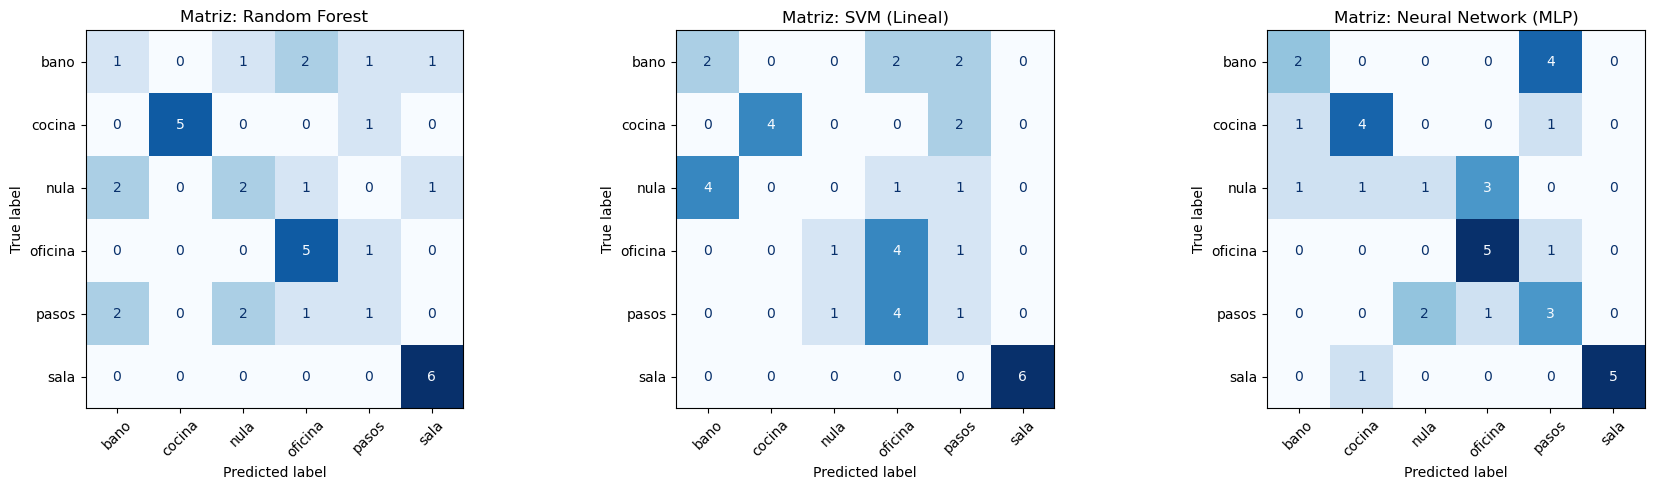

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (nombre, modelo) in enumerate(modelos.items()):
    y_pred = modelo.predict(X_test_scaled)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        ax=axes[i], 
        cmap='Blues', 
        xticks_rotation=45,
        colorbar=False
    )
    axes[i].set_title(f"Matriz: {nombre}")

plt.tight_layout()
plt.show()

## 6. Conclusiones
Después de todo el proceso, queda claro que el tiempo que pasas limpiando y preparando los datos es mucho más determinante que el modelo que elijas al final. Al inicio de la practica, se hicieron pruebas rápidas con 7 modelos distintos (como k-NN y Regresión Logística) y se seleccionaron los mencionados anteriormente, esto porque representan tres formas de "pensar" totalmente diferentes(votacion, fronteras geometricas y procesamiento por capas) y era lo que mejor permitía entender cómo la IA estaba interpretando los audios.

Se observó que sin aplicarle el recorte de ruido, la IA se distraía con los segundos de silencio de las grabaciones, lo que hacía que las métricas bajaran. Al meter la limpieza de señal, los resultados se volvieron más consistentes. Por lo tanto, menos es mas en este tipo de trabajos.

La Sala siempre tuvo un F1-score de 1.00. Esto dice que hay entornos con una firma acústica tan única que no necesitan modelos complejos para ser detectados. El SVM es excelente para cosas específicas, pero si quiero un sistema que se equivoque menos en general, la Red Neuronal (MLP) fue el que mejor aguantó la variedad de audios de los 179 ejemplos.

Un punto que me llamó la atención fue la confusión entre el Baño y la clase Nula. Al ser un dataset de todo el grupo, no tenemos ni idea de qué grabaron los demás como "otros sonidos" en la categoría Nula. Esa falta de control hace que el modelo reciba un montón de ruidos diferentes que terminan pareciéndose a bajarle al WC. Al final el introducir una clase con sonidos diferentes entre si, hace que los MFCC se confundan fácil con cualquier sonido ambiental que no esté bien definido.

En resumen, La IA es muy sensible a lo que le entregas. Si la señal de entrada no es consistente, el modelo más avanzado del mundo va a fallar. Esta practica fue un ejercicio de iteración: ver qué fallaba, regresar al preprocesamiento y volver a intentar.